# **Experiment Notebook**



In this experiment, a Support Vector Classifier (SVC) is employed to predict NBA draft outcomes by evaluating player data, including performance metrics and physical characteristics, to estimate the probability of a player being selected in the draft.

### 0. Import Packages

In [1]:
%load_ext autoreload
%autoreload 2
!pip3 install -i https://test.pypi.org/simple/ grp_krml_group6==2024.0.1.0 #using pypi package

Looking in indexes: https://test.pypi.org/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from scipy.stats import uniform, loguniform
from grp_krml_group6.data.sets import pop_target, data_cleaning, roc_curve_plot, distribution_plot, categorical_plot, confusion_matrix_plot, relationship_plot

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#  set path of the data
train_file_url = '../data/raw/train.csv'
test_file_url = '../data/raw/test.csv'

In [5]:
# read the csv data
train_df = pd.read_csv(train_file_url)
test_df = pd.read_csv(test_file_url)

In [6]:
# checking the shape of the data
train_df.shape, test_df.shape

((46618, 64), (4970, 63))

### 1. Prepare Data

In [7]:
# copy data for cleaning
df_cleaned = train_df.copy()
df_clean_test = test_df.copy()

In [8]:
# drop Irrelevant Features
df_cleaned.drop(columns=['player_id', 'year', 'team'], inplace=True)
df_clean_test.drop(columns=['player_id', 'year', 'team'], inplace=True)

# dropping columns with a large amount of missing data (e.g., Rec_Rank)
df_cleaned.drop('Rec_Rank', axis=1, inplace=True)
df_clean_test.drop('Rec_Rank', axis=1, inplace=True)

In [9]:
# height transformation:
month_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4,
    "May": 5, "Jun": 6, "Jul": 7, "Aug": 8,
    "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

def convert_height(ht_value):
    try:
        feet, inches = ht_value.split('-')
        inches = month_mapping.get(inches, inches)  # Convert month-like string to a number
        return int(feet) * 12 + int(inches)
    except (ValueError, AttributeError):
        return np.nan

In [10]:
# Listing num and cat cols
num_cols = ['ast_tov', 'rimmade', 'midmade', 'rim_ratio', 'mid_ratio', 'dunks_ratio', 'pick']
cat_cols = ['num', 'ht', 'yr']

In [11]:
# Data cleanig using Pypi function
df_cleaned = data_cleaning(df_cleaned, 
                           num_columns = num_cols, 
                           cat_columns = cat_cols, 
                           special_column_transformations={'ht': convert_height})
X_test = data_cleaning(df_clean_test, 
                           num_columns = num_cols, 
                           cat_columns = cat_cols, 
                           special_column_transformations={'ht': convert_height})

In [12]:
# split the data into features (X) and target (y)
X, y = pop_target(df_cleaned, 'drafted')

In [13]:
# further split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [14]:
# define the preprocessing pipeline
categorical_columns = ['conf', 'yr', 'type']  # Adjust as needed
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

In [15]:
# create the Logistic Regression pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])

In [16]:
# parameter grid for RandomizedSearchCV
param_distributions = {
    'classifier__C': loguniform(1e-3, 1e3),
    'classifier__gamma': loguniform(1e-3, 1e1),
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__degree': np.arange(2, 5),  # Only applicable if kernel is 'poly'
}

# randomized search over the parameter grid
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, scoring='roc_auc', cv=5, random_state=42)

In [17]:
# train the model
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['GP',
                                                                                'Min_per',
                                                                                'Ortg',
                                                                                'usg',
                                                                                'eFG',
                                                                                'TS_per',
                                                                                'ORB_per',
                                                                                'DRB_per',
                                                                                'AST_per',
                                                                                'TO_per',
                                                                                'FTM',
                                                                                'FTA',
                                                                                'FT_per',
                                                                                'twoPM',
                                                                                'twoPA',
                                                                                'twoP_per',
                                                                                'TPM',
                                                                                'TPA',
                                                                                'TP_per',
                                                                                'blk_per',
                                                                                'stl_per',
                                                                                'ftr',
                                                                                'ht',
                                                                                'porpag',
                                                                                'adjoe',
                                                                                'pfr',
                                                                                'ast_tov',
                                                                                'rimmade',
                                                                                'r...
                                              SVC(probability=True,
                                                  random_state=42))]),
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x11c9ac390>,
                                        'classifier__degree': array([2, 3, 4]),
                                        'classifier__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x11c9acbd0>,
                                        'classifier__kernel': ['linear', 'rbf',
                                                               'poly']},
                   random_state=42, scoring='roc_auc')

In [18]:
# show best parameters
random_search.best_params_

{'classifier__C': np.float64(0.1767016940294795),
 'classifier__degree': np.int64(2),
 'classifier__gamma': np.float64(0.0054167545832474575),
 'classifier__kernel': 'linear'}

In [19]:
# assign best model
best_model = random_search.best_estimator_

In [20]:
# predict on the test set
y_pred = best_model.predict(X_train)
y_pred_proba = best_model.predict_proba(X_train)[:, 1]  # Get the probability estimates for the positive class

In [21]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     32321
         1.0       0.81      0.25      0.38       311

    accuracy                           0.99     32632
   macro avg       0.90      0.63      0.69     32632
weighted avg       0.99      0.99      0.99     32632



In [22]:
# ROC AUC Score
roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 0.9898


In [23]:
# Predict on the test set
y_pred_val = best_model.predict(X_val)
y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]  # Get the probability estimates for the positive class

In [24]:
# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba_val)
print(f'\nROC AUC Score: {roc_auc:.4f}')


ROC AUC Score: 0.9898


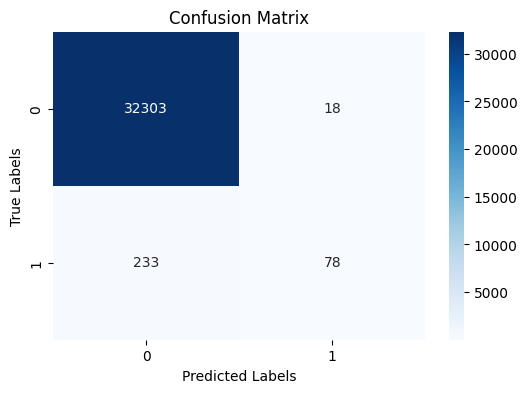

In [25]:
# Confusion Matrix
# Compute the confusion matrix
confusion_matrix_plot(y_train, y_pred)

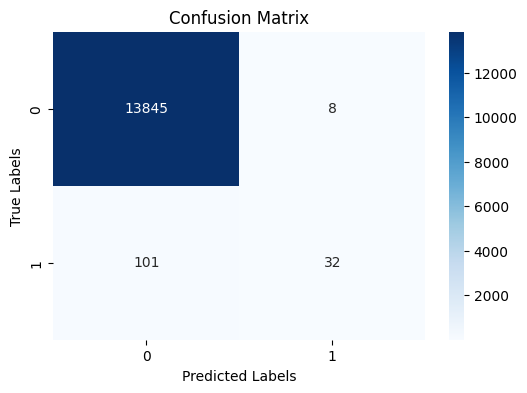

In [26]:
# Confusion Matrix
confusion_matrix_plot(y_val, y_pred_val)

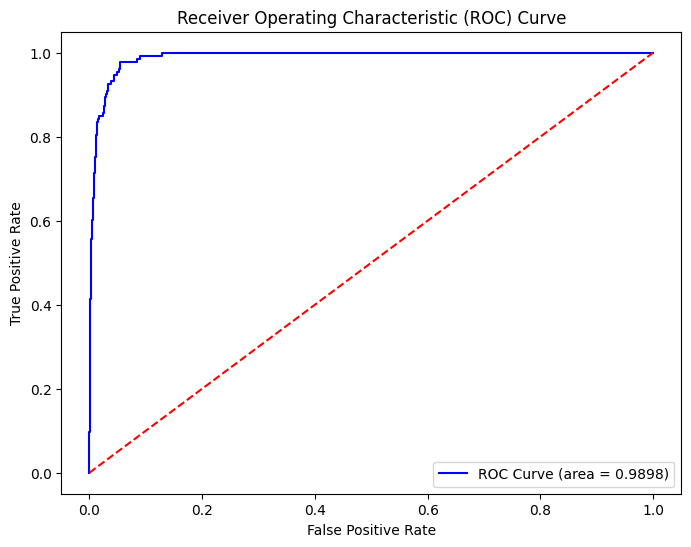

In [27]:
# Plot ROC Curve
roc_curve_plot(y_val, y_pred_proba_val)

In [29]:
test_df['predicted_probability'] = best_model.predict_proba(X_test)[:,1]

In [30]:
test_df[['player_id', 'predicted_probability']].to_csv('submission.csv', index=False)

In [31]:
test_df[['player_id', 'predicted_probability']]

,player_id,predicted_probability
0,23549e01-c1b3-4ca0-a0fd-de9b5d76276b,3.366858e-07
1,52a518bb-b34a-4b43-adee-5e996cb853fa,3.101808e-06
2,ad3d9117-b6bf-4675-ab97-3497acf3e555,1.438461e-04
3,eaf66a5c-6f4c-4070-bc70-a99d731b3740,6.425526e-05
4,55d07491-5bd1-447f-844e-9cb36eaa442e,2.370861e-03
...,...,...
4965,28222513-8a1f-4a48-8fde-16888e9e11ce,1.000000e-07
4966,c32a466d-7a66-47eb-805c-a94e328261bc,4.215805e-05
4967,55f0ddef-9f29-47ae-87b5-da43c687d25c,1.465952e-05
4968,460d6a42-5dbc-48f0-bc94-3650da83f345,3.542410e-05


The ROC AUC curve on the validation set shows an excellent performance, with an AUC of 0.9898, indicating that the model has a strong ability to differentiate between "drafted" and "notDrafted" players. However, on the test set, the ROC AUC score is 0.888, which, while still good, suggests a slight drop in performance when applied to unseen data.